# Prepare and Visualize dataset

Update fastai library

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Import Python libraries

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

Define Path where dataset is located

In [0]:
path = Path('drive/My Drive/Covid19/dataset_fastai/')

Check what's inside the dataset

In [0]:
path.ls()

[PosixPath('drive/My Drive/Covid19/dataset_fastai/pneumonia'),
 PosixPath('drive/My Drive/Covid19/dataset_fastai/train'),
 PosixPath('drive/My Drive/Covid19/dataset_fastai/validation'),
 PosixPath('drive/My Drive/Covid19/dataset_fastai/models'),
 PosixPath('drive/My Drive/Covid19/dataset_fastai/test'),
 PosixPath('drive/My Drive/Covid19/dataset_fastai/normal'),
 PosixPath('drive/My Drive/Covid19/dataset_fastai/models2'),
 PosixPath('drive/My Drive/Covid19/dataset_fastai/export.pkl')]

Visualize one of the images

torch.Size([3, 362, 445])


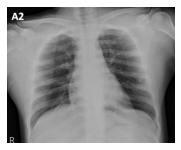

In [0]:
img = open_image(path/'train/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png')
print(img.data.shape)
img.show()

Define some training parameters

In [0]:
batch_size = 16
np.random.seed(7)

Augment Data by rotating images randomly (Can be improved by adding more meaningful transformations)

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=False, max_rotate=25)

Load Images in an ImageDataBunch object

In [0]:
data = ImageDataBunch.from_folder(path, train="train", valid='validation', test='test', ds_tfms=tfms, size=224, bs=batch_size, num_workers=4).normalize(imagenet_stats)

Show some Images

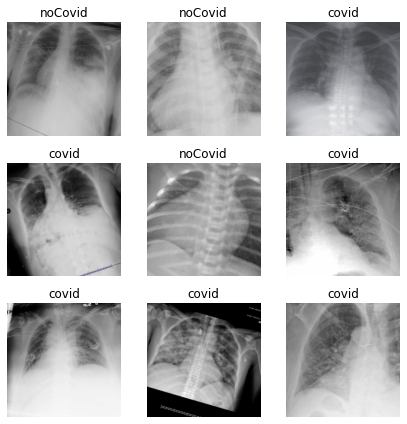

In [0]:
data.show_batch(3, figsize=(6,6))

Check dataset distribution

In [0]:
data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds), len(data.classes)

(2, 154, 80, 83, 2)

# Build and Generate the classifier

We will use a pretrained resnet34 (Check other types of metrics)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.002831,0.502788,0.137500,00:56
1,0.776730,0.291998,0.062500,00:15
2,0.672817,0.290391,0.075000,00:15
3,0.619613,0.208762,0.062500,00:15


In [0]:
base_dir = "drive/My Drive/Covid19/dataset_fastai/"
dest=Path(base_dir + "models2/covidnocovid/")
try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ("File Already Exists")

File Already Exists


In [0]:
print(dest)

drive/My Drive/Covid19/dataset_fastai/models2/covidnocovid


In [0]:
!pwd

/content


In [0]:
learn.save(dest/"/covidnocovid_stage-1")

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

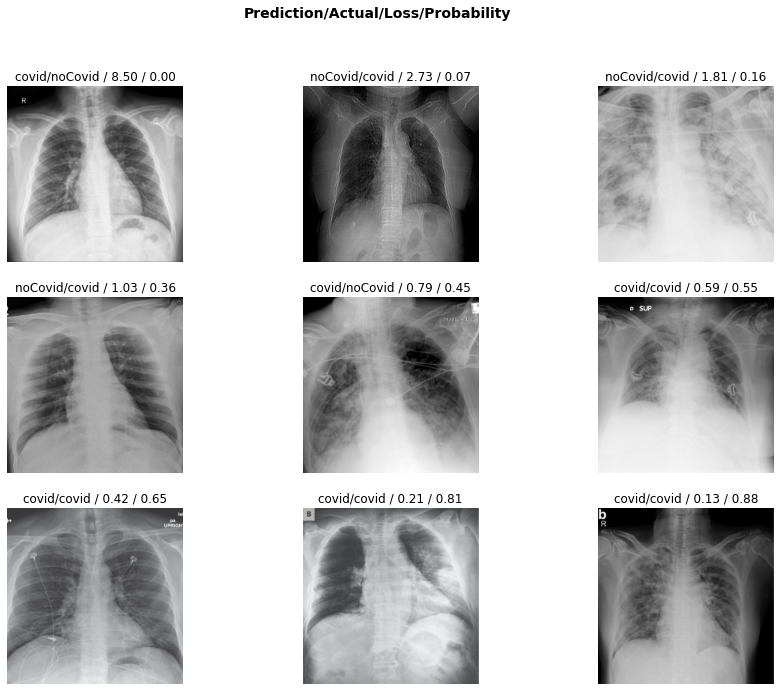

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

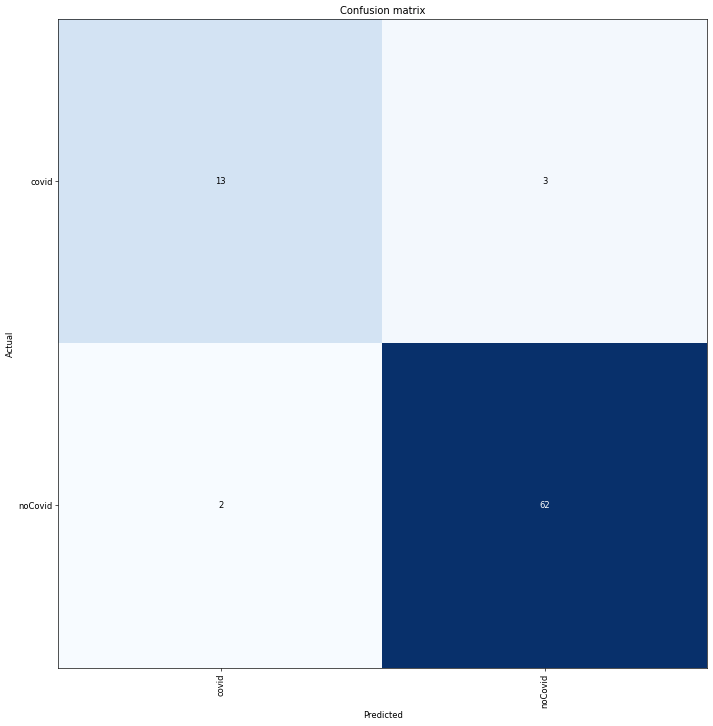

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Improve Results

Unfreeze model

In [0]:
learn.unfreeze()

Find recomended learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


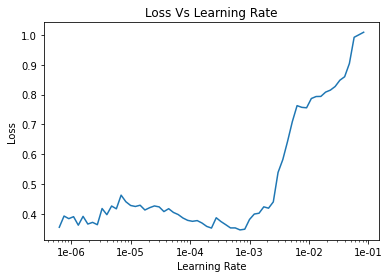

In [0]:
learn.lr_find()
learn.recorder.plot()
plt.title("Loss Vs Learning Rate")
plt.show()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-4, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.307314,0.167319,0.050000,00:15
1,0.341035,0.211879,0.050000,00:15
2,0.314916,0.157662,0.075000,00:15
3,0.280050,0.167298,0.037500,00:16
4,0.346047,0.432423,0.062500,00:15
5,0.309322,0.383720,0.037500,00:16
6,0.299948,0.373151,0.050000,00:16
7,0.269575,0.310792,0.050000,00:15
8,0.239711,0.309567,0.037500,00:15
9,0.235582,0.295560,0.037500,00:15


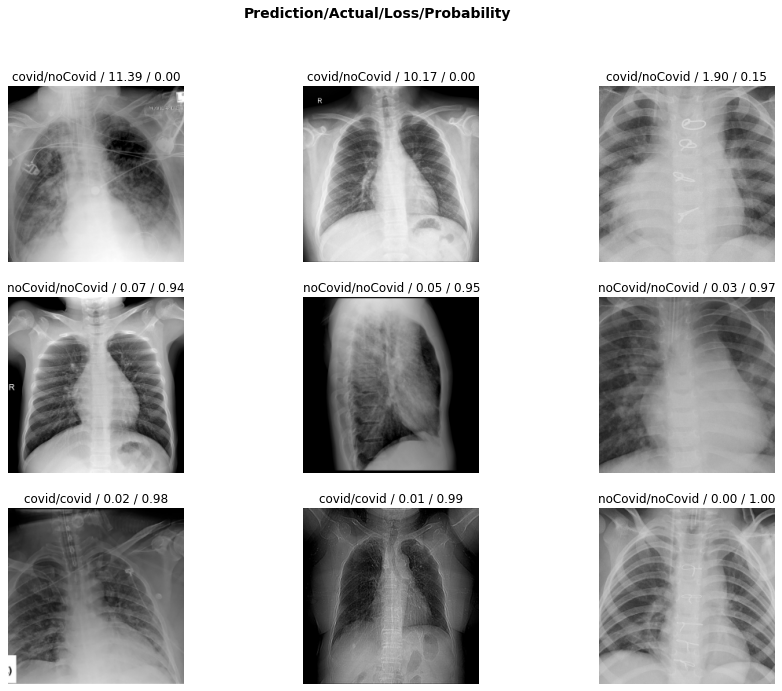

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
learn.save('./covidnocovid_stage-4')

In [0]:
print(learn.path)

drive/My Drive/Covid19/dataset_fastai


In [0]:
# This will create the file export.pkl which we can load afterwards in order to perform inference
learn.export()

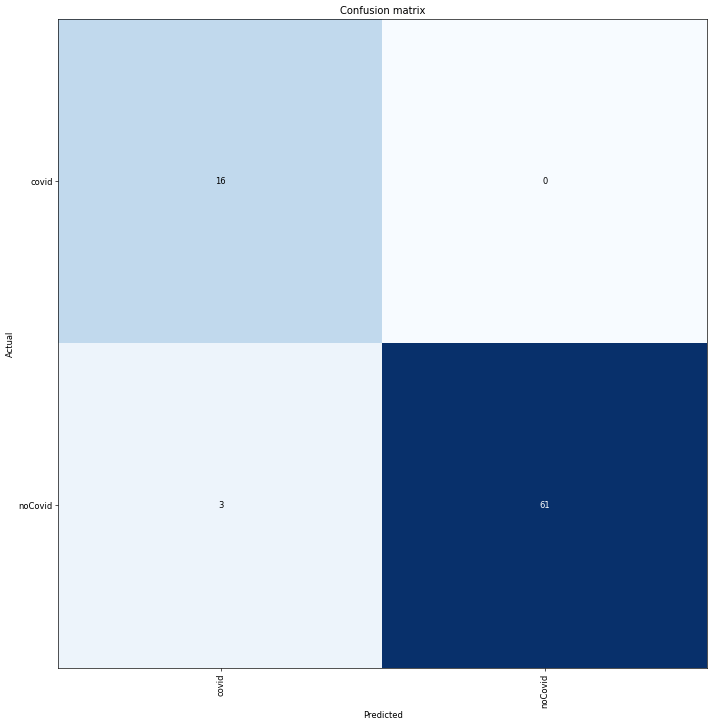

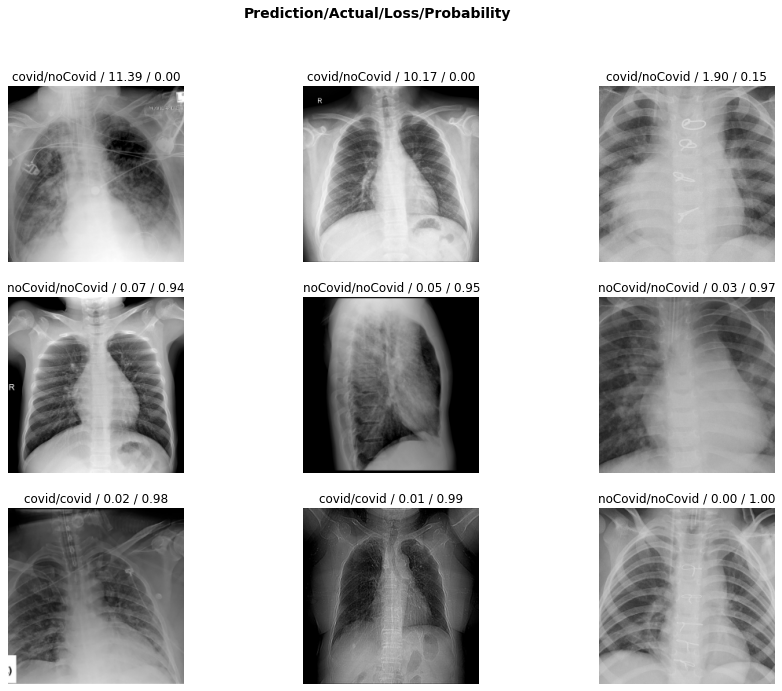

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.plot_top_losses(9, figsize=(15,11))

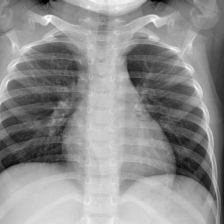

In [0]:
img = learn.data.test_ds[54][0]
img

In [0]:
learn.predict(img)

(Category noCovid, tensor(1), tensor([1.3533e-09, 1.0000e+00]))